In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import sep
from matplotlib.patches import Ellipse
from astropy.stats import sigma_clipped_stats

In [2]:
im_test='./WCS_Solved/NGC6365A/NGC6365A_R.fits'
image=fits.open(im_test)[0].data
hdr=fits.open(im_test)[0].header
wcs=WCS(hdr)
data=image.byteswap().newbyteorder()
targets={'NGC3705': SkyCoord("11:30:07 +09:16:36",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:55 +30:16:11",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:05 +32:44:06",unit=('hourangle,deg')),
         'UGC9374': SkyCoord("14:33:59 +40:14:40",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57 +40:23:59",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44 +62:09:58",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:51 +12:41:43",unit=('hourangle,deg'))}
target=im_test.split('/')[-2]
target_x,target_y=wcs.world_to_pixel(targets[target])
print(target)
print(wcs)

NGC6365A
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 260.743780629  62.1949016847  
CRPIX : 671.858985901  697.169605255  
CD1_1 CD1_2  : -0.000174444461635  9.54768630134e-07  
CD2_1 CD2_2  : -1.02498453117e-06  -0.000174289248574  
NAXIS : 2048  2054


In [3]:
bkg = sep.Background(data)
print(bkg.globalback)
print(bkg.globalrms)
data_sub=data-bkg.globalback
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print((mean, median, std)) 

402.53289794921875
8.432629585266113
(403.02245124060386, 402.8877062267163, 8.814131853595656)


In [4]:
objects,seg_map = sep.extract(data_sub, 5, err=bkg.globalrms,segmentation_map=True)
#objects,seg_map = sep.extract(data_sub, 5, err=bkg.globalrms,segmentation_map=True,deblend_cont=1)#use if no blending wanted
#seg_map=np.full(image.shape,dtype=int,)
dists=np.sqrt((objects['x']-target_x)**2+(objects['y']-target_y)**2)
obj=np.argmin(dists)
print(objects[obj])
x=objects['x'][obj]
y=objects['y'][obj]
a=objects['a'][obj]
b=objects['b'][obj]
#print(x,y)
obj_seg=seg_map[int(y),int(x)]
print(obj,obj_seg)
theta=objects['theta'][obj]#
#print(x,y)
#print(objects['npix'])
#print(objects['npix'][obj])


(42.16314697, 3011, 2849, 793, 868, 817, 893, 835.01642747, 859.56414203, 180.34475456, 151.08350877, 2.85993677, 0.00052463, 0.00043525, 1.43378141e-05, 13.43955612, 12.28033447, 0.09652094, 0.0055466, 0.00662084, -0.00020999, 341732.40625, 342450.90625, 968.41870117, 1090.70959473, 836, 860, 836, 860, 1)
366 367


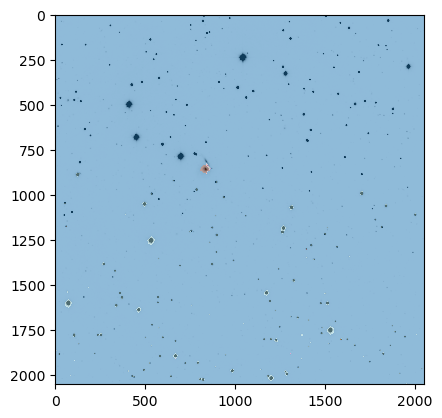

In [5]:
plt.imshow(image,vmin=bkg.globalback,vmax=2*bkg.globalback,cmap='Greys')
plt.imshow(seg_map,vmin=obj_seg-1,vmax=obj_seg+1,cmap='tab20',alpha=0.5)
#plt.xlim(700,1100)
#plt.ylim(700,1100)

In [206]:
mask = np.zeros(data.shape, dtype=bool)
print(type(mask))
#print(type(sep.mask_ellipse(mask,objects['x'][0],objects['y'][0],objects['a'][0],objects['b'][0],objects['theta'][0],r=6)))
for i in [el for el in range(len(objects)) if el!=obj]:
    sep.mask_ellipse(mask,objects['x'][i],objects['y'][i],objects['a'][i],objects['b'][i],objects['theta'][i],r=6)
test=image.copy()
trues=0
for i in range(len(mask)):
    for j in range(len(mask[i])):
        if mask[i][j]==True:
            test[i][j]=bkg.globalback
            trues+=1
print(trues)


<class 'numpy.ndarray'>
40658


366
366


(760.0, 1000.0)

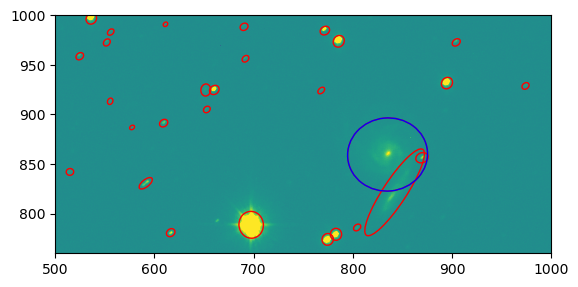

In [6]:
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='viridis',
               vmin=m-s, vmax=m+s, origin='lower')
areas=[]
# plot an ellipse for each object
for i in range(len(objects)):
    areas.append(np.pi*objects['a'][i]*objects['b'][i])
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
print(np.argmax(areas))
e1 = Ellipse(xy=(objects['x'][obj], objects['y'][obj]),
                width=6*objects['a'][obj],
                height=6*objects['b'][obj],
                angle=objects['theta'][obj] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax.add_artist(e1)
#plt.xlim(900,1200)
#plt.ylim(900,1200)
print(obj)
plt.xlim(500,1000)
plt.ylim(760,1000)

In [17]:
#For ngc3705 add a different seg id
kronrad, krflag = sep.kron_radius(data, [x], [y], [a], [b], [theta], 6.0,segmap=seg_map,seg_id=[obj_seg])
flux, fluxerr, flag = sep.sum_ellipse(data, [x], [y], [a], [b], [theta], 2*kronrad,
                                      subpix=1,bkgann=(3.*kronrad,3.5*kronrad),segmap=seg_map,seg_id=[obj_seg])
ell_flux,ell_fluxerr,flag=sep.sum_ellipse(data, [x], [y], [a], [b], [theta], 2.5*kronrad,
                                      subpix=1,segmap=seg_map,seg_id=[obj_seg])
ann_flux,ann_fluxerr,flag=sep.sum_ellipann(data, [x], [y], [a], [b], [theta],3.5*kronrad,4*kronrad,segmap=seg_map,seg_id=[obj_seg],subpix=1)
flag |= krflag  # combine flags into 'flag'
print(flux)
ann_area=np.pi*a*b*((3.5*kronrad)**2-(3*kronrad)**2)
app_area=np.pi*(a*b*(2.5*kronrad)**2)
#print(ann_area)
#print(app_area)
#print(ell_flux)
#ann_flux=(n)
net=ell_flux-ann_flux*(app_area/ann_area)
sky=ann_flux*(app_area/ann_area)
print(net)
print(sky/app_area)
print('S/N=',(net)/np.sqrt(net+sky))

[533600.49256612]
[-3102810.69898517]
[460.75627375]
S/N= [-697.02048625]


In [9]:
mask = np.zeros(data.shape, dtype=bool)
print(type(mask))
#print(type(sep.mask_ellipse(mask,objects['x'][0],objects['y'][0],objects['a'][0],objects['b'][0],objects['theta'][0],r=6)))
for i in [el for el in range(len(objects)) if el!=obj]:
    sep.mask_ellipse(mask,objects['x'][i],objects['y'][i],objects['a'][i],objects['b'][i],objects['theta'][i],r=6)
test=image.copy()
trues=0
for i in range(len(mask)):
    for j in range(len(mask[i])):
        if (seg_map[i][j]!=obj_seg) and seg_map[i][j]!=0: 
        #if (seg_map[i][j]!=obj_seg) and (seg_map[i][j]!=obj_seg+1)and seg_map[i][j]!=0: for NGC3705, replace previous
            test[i][j]=bkg.globalback
            trues+=1
print(trues)


<class 'numpy.ndarray'>
62154


(750.0, 1000.0)

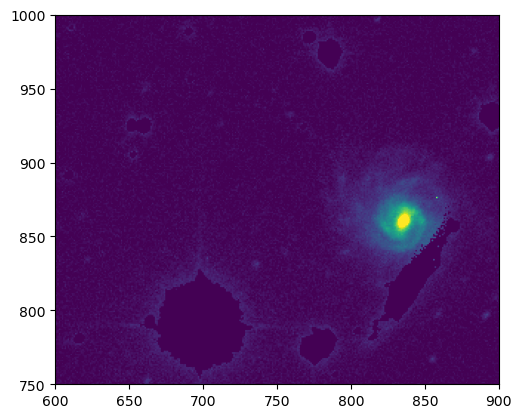

In [10]:
plt.imshow(test,vmin=bkg.globalback,vmax=2*bkg.globalback,cmap='viridis')
plt.xlim(600,900)
plt.ylim(750,1000)

(700.0, 1000.0)

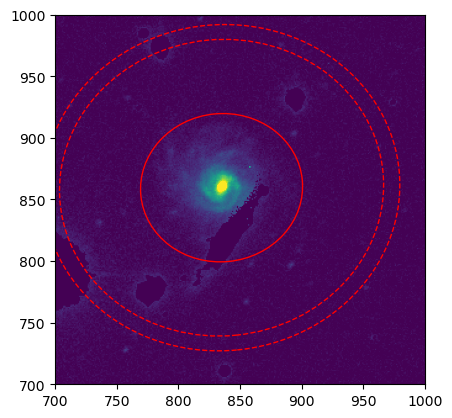

In [13]:
fig, ax = plt.subplots()
ax.imshow(test,vmin=bkg.globalback,vmax=2*bkg.globalback,cmap='viridis')
mask = np.zeros(data.shape, dtype=bool)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax.add_artist(e_app)
e_ann_in = Ellipse(xy=(x, y),
                width=5*kronrad*a,
                height=5*kronrad*b,
                angle=theta*(180/np.pi),
                ls='--')
e_ann_in.set_facecolor('none')
e_ann_in.set_edgecolor('red')
ax.add_artist(e_ann_in)
e_ann_out = Ellipse(xy=(x, y),
                width=5.5*kronrad*a,
                height=5.5*kronrad*b,
                angle=theta*(180/np.pi),
                ls='--')
e_ann_out.set_facecolor('none')
e_ann_out.set_edgecolor('red')
ax.add_artist(e_ann_out)
plt.xlim(700,1000)
plt.ylim(700,1000)

65165
402.5350341796875
8.430824279785156
(402.6104231897684, 402.535888671875, 1.7612333276529728)


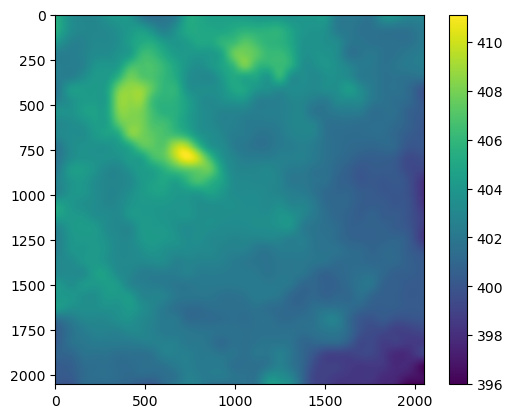

In [272]:
bkg_mask=np.zeros(data.shape,dtype=bool)
masked_pixels=0
for i in range(len(data)):
    for j in range(len(data[i])):
        if seg_map[i][j]!=0:
            bkg_mask[i][j]=True
            masked_pixels+=1
print(masked_pixels)
newbkg=sep.Background(data,mask=bkg_mask)
plt.imshow(newbkg.back())
plt.colorbar()
print(newbkg.globalback)
print(newbkg.globalrms)
print(sigma_clipped_stats(newbkg,sigma=3))
